In [22]:
import numpy as np
import pandas as pd
import pydicom
import time
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.image as immg

import warnings
warnings.filterwarnings("ignore")

In [23]:
path = '../input/vinbigdata-resized-image-512/'
df = pd.read_csv('../input/vinbigdata-weighted-bbox-fusion/weighted_box_fused_train_vinBigData.csv')
df.head()

,image_id,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,14,wbf,0.000000,0.000000,1.000000,1.000000
1,21a10246a5ec7af151081d0cd6d65dc9,14,wbf,0.000000,0.000000,1.000000,1.000000
2,9a5094b2563a1ef3ff50dc5c7ff71345,3,wbf,690.666676,1354.333235,1658.666714,1797.666677
3,9a5094b2563a1ef3ff50dc5c7ff71345,0,wbf,1052.000000,715.000000,1299.000000,966.000000
4,9a5094b2563a1ef3ff50dc5c7ff71345,11,wbf,1789.000000,1729.000000,1875.000000,1992.000000


In [24]:
# replace NaN by 0
df = df.fillna(0)

In [25]:
img_dim = pd.read_csv('../input/vinbigdata-resized-image-512/train_meta.csv')

In [26]:
df = df.merge(img_dim,on='image_id',how='left')

In [27]:
df['x_min'] = df['x_min']*512/df['dim1']
df['x_max'] = np.ceil(df['x_max']*512/df['dim1'])
df['y_min'] = df['y_min']*512/df['dim0']
df['y_max'] = np.ceil(df['y_max']*512/df['dim0'])

In [28]:
df.describe()

,class_id,x_min,y_min,x_max,y_max,dim0,dim1
count,34510.000000,34510.000000,34510.000000,34510.000000,34510.000000,34510.000000,34510.000000
mean,9.320632,147.300599,132.937163,203.479252,179.701941,2838.098870,2493.697711
std,4.774856,138.360779,122.549886,168.006037,148.330784,292.973949,355.930804
min,0.000000,0.000000,0.000000,1.000000,1.000000,927.000000,823.000000
25%,6.000000,0.000000,0.000000,1.000000,1.000000,2615.000000,2304.000000
50%,11.000000,121.470445,115.621184,202.000000,185.000000,2880.000000,2453.000000
75%,14.000000,266.795256,229.463041,364.000000,311.000000,3072.000000,2742.000000
max,14.000000,496.250000,493.213918,512.000000,512.000000,3408.000000,3320.000000


In [29]:
df.columns

Index(['image_id', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max',
       'dim0', 'dim1'],
      dtype='object')

In [30]:
df = df[df['class_id']!=14]
df['class_id'] = df['class_id']+1

In [31]:
df = df.reset_index(drop=True)

In [32]:
df_grp = df.groupby(['image_id'])
b_fea = ['x_min', 'y_min', 'x_max', 'y_max']

In [33]:
import matplotlib

## Sample Image

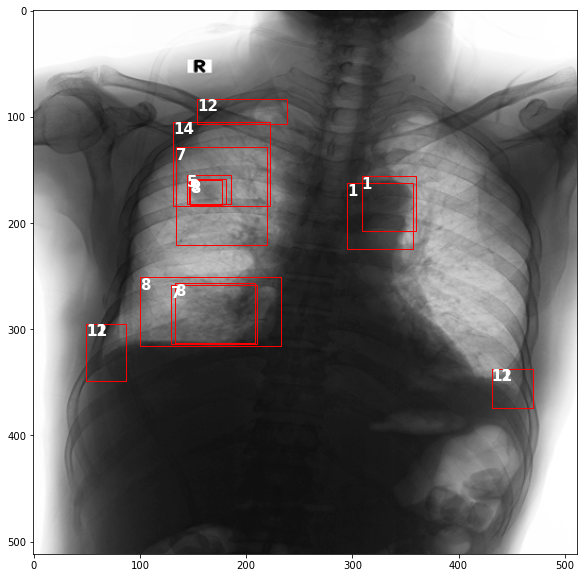

In [34]:
name = df.image_id.tolist()[85]
loc = '../input/vinbigdata-resized-image-512/train/'+name+'.png'
aaa = df_grp.get_group(name)
bbx = aaa.loc[:,b_fea]
img = immg.imread(loc)
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img,cmap='binary')
for i in range(len(bbx)):
    box = bbx.iloc[i].values
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], aaa['class_id'].iloc[i], verticalalignment='top', color='white', fontsize=15, weight='bold')
    ax.add_patch(rect)
plt.show()

## Dataset

In [35]:
img_dir = "../input/vinbigdata-resized-image-512/train/"

In [363]:
class XrayDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].unique().tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".png",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = records['class_id'].tolist()
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        
        return torch.tensor(image), target, image_id

In [364]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    #img = cv2.resize(data,(512,512)).astype(np.float32)
    
    return np.dstack((data,data,data))

In [365]:
ts_img_dir1 = '../input/vinbigdata-chest-xray-abnormalities-detection/test/'
ts_img_dir2 = '../input/vinbigdata-resized-image-512/test/'

In [405]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        #image = read_xray(ts_img_dir+image_id+".dicom")
        image = cv2.imread(self.img_dir+image_id+".png",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id,image.shape[1],image.shape[2]


## Transforms

In [367]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [368]:
CDS = XrayDataset(df, img_dir ,get_train_transform())

### Dataset Sample

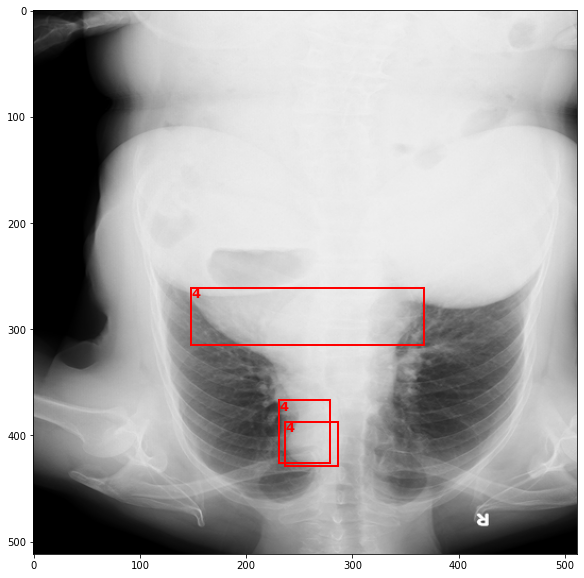

In [39]:
import random
img, tar,_ = CDS[random.randint(0,1000)]
bbox = tar['boxes'].numpy()
labels = tar['labels'].numpy()
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], labels[0], verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [40]:
image_ids = df['image_id'].unique()
train_ids = image_ids[:3075]
valid_ids = image_ids[3075:]
train_df = df[df['image_id'].isin(train_ids)]
valid_df = df[df['image_id'].isin(valid_ids)]
train_df.shape,valid_df.shape

((19101, 9), (4803, 9))

## Dataloader

In [369]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = XrayDataset(train_df,img_dir , get_train_transform())
valid_dataset = XrayDataset(valid_df,img_dir, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model Faster RCNN pretrained 

In [43]:
num_classes = len(df['class_id'].unique())+1  # 1 class (wheat) + background
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [44]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

In [45]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Training

In [46]:
num_epochs = 15

In [ ]:
loss_hist = Averager()
best_epoch = 0
min_loss = sys.maxsize
for epoch in range(num_epochs):
    loss_hist.reset()
    tk = tqdm(train_data_loader)
    for images, targets, image_ids in tk:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    
    if loss_hist.value<min_loss:
        print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
        torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")
        min_loss = loss_hist.value
        best_epoch = epoch
        
model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));

<h2 align=center style="color:blue; border:1px dotted blue">Validation and Prediction</h2>

#### Below apply_nms function

**Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).**

**NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.**

**If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.**

Source : https://pytorch.org/vision/stable/ops.html

In [47]:
model.load_state_dict(torch.load('../input/vinbigdata-abnormalities-detection-imgx512/model_state_epoch_12.pth'));

In [48]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

### Let's take a sample from valid dataset and make Prediction

In [378]:
submission = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv')

In [379]:
ts_ids = submission.image_id.unique().tolist()

In [419]:
TCDS = TestDataset(submission,ts_img_dir2,get_test_transform())

In [420]:
img,_,_,_ = TCDS[0]

In [422]:
test_data_loader = DataLoader(
    TCDS,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## Prediction on Test Set

In [423]:
results = []

with torch.no_grad():

    for images, image_ids,_,_ in tqdm(test_data_loader):

        images = list(image.to(device) for image in images)
        outputs = model(images)
        results.append(outputs)

  0%|          | 0/375 [00:00<?, ?it/s]

In [427]:
img,target,_ = valid_dataset[58]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  94
real #boxes:  1


## Plotting Predictions

In [460]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5,iou_thresh=0.2):
    '''
    img = val_image
    nms = use non maximum-supression 
    prediction dict
    detection threshold
    intersection over union threshold for non-maximum suppression (NMS)
    '''
    fig,ax = plt.subplots(figsize=(8,8))
    val_img = img.permute(1,2,0).cpu().detach().numpy()
    ax.imshow(val_img)
    nms_prediction = apply_nms(prediction, iou_thresh=iou_thresh) if nms else prediction
    val_scores = nms_prediction['scores'].cpu().detach().numpy()
    bbox = nms_prediction['boxes'].cpu().detach().numpy()
    lbls = nms_prediction['labels'].cpu().detach().numpy()
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
            ax.text(*box[:2], "Class {0} | {1:.3f}".format(lbls[i],val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()

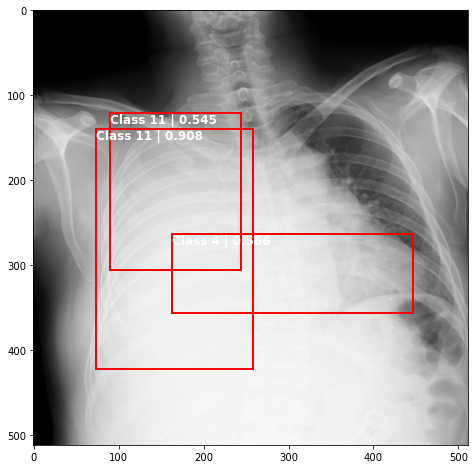

In [461]:
plot_valid(img,prediction,False)

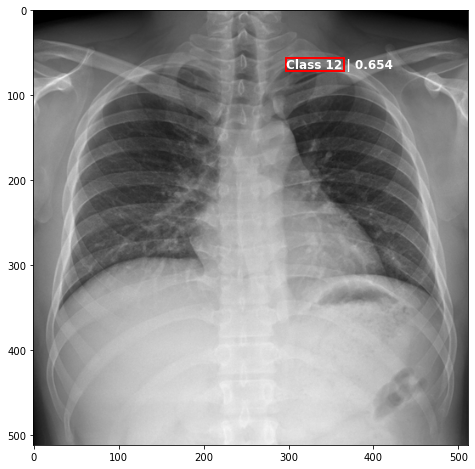

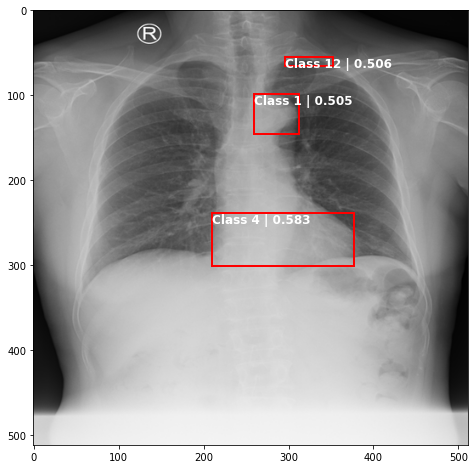

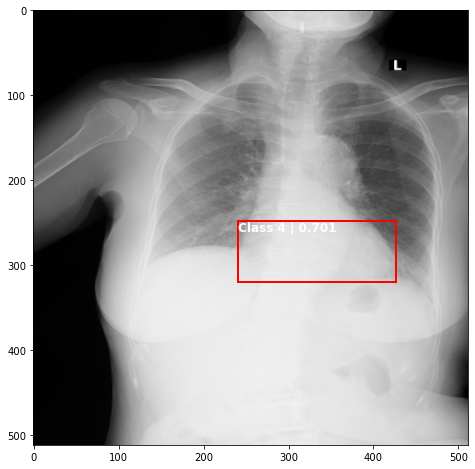

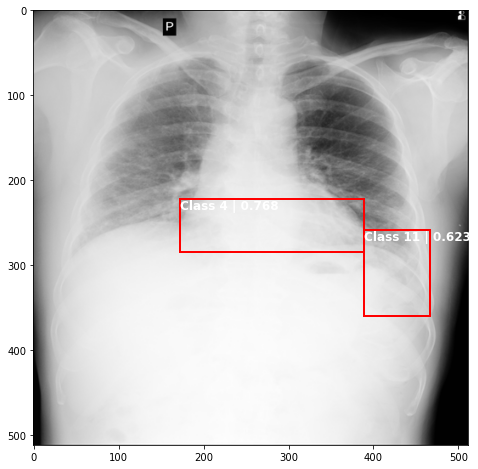

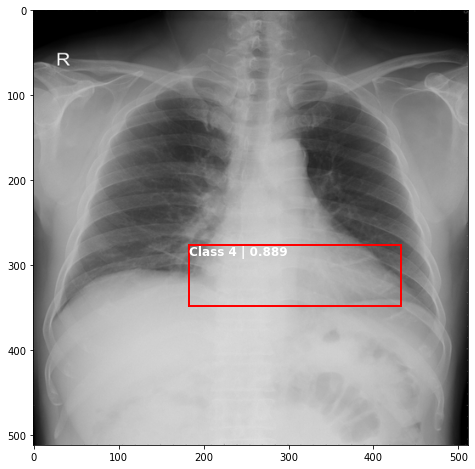

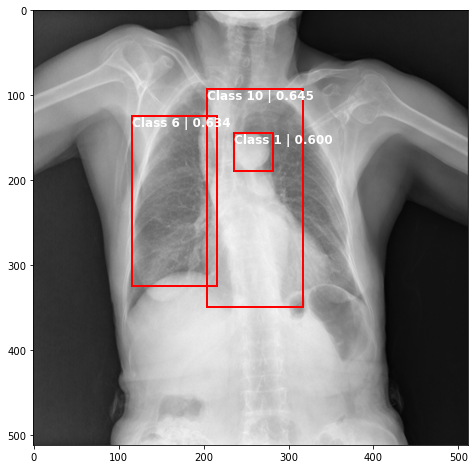

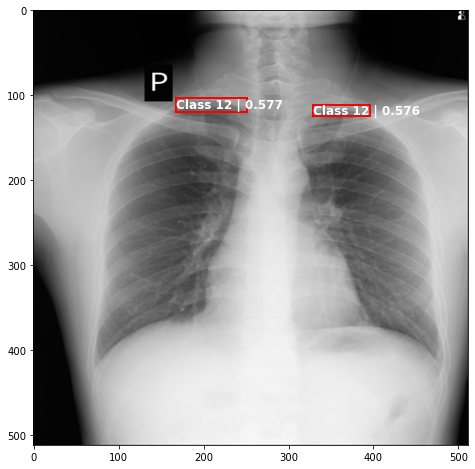

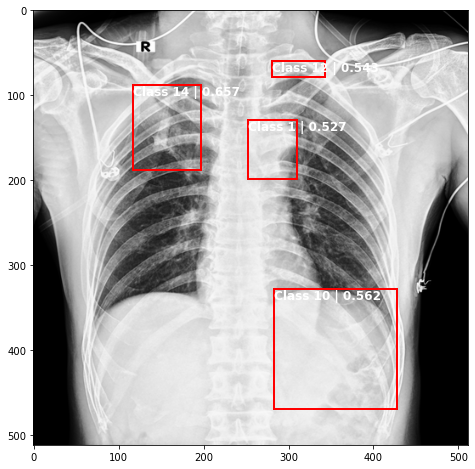

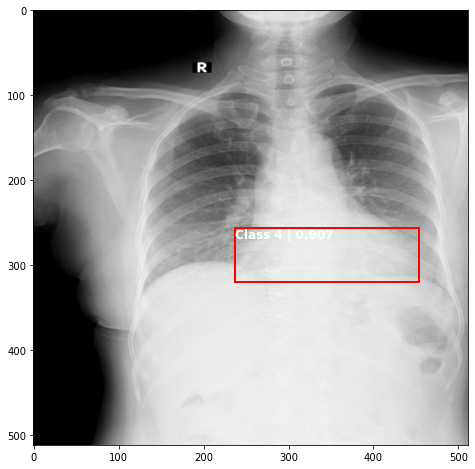

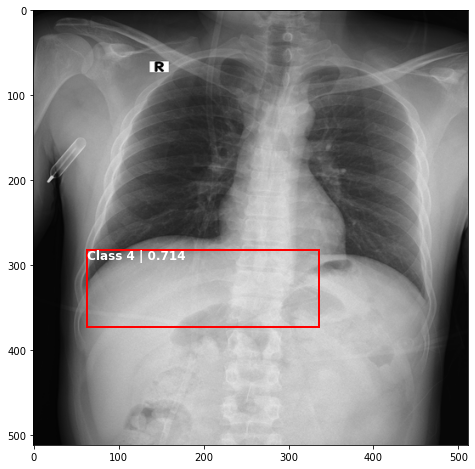

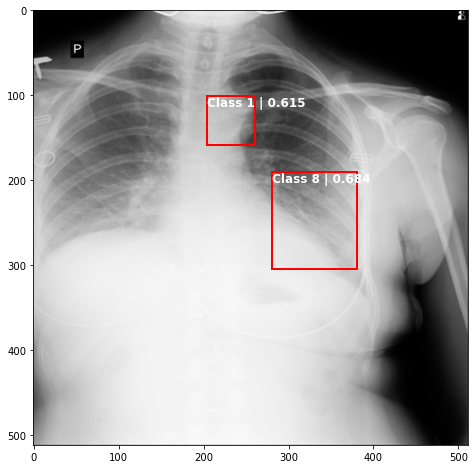

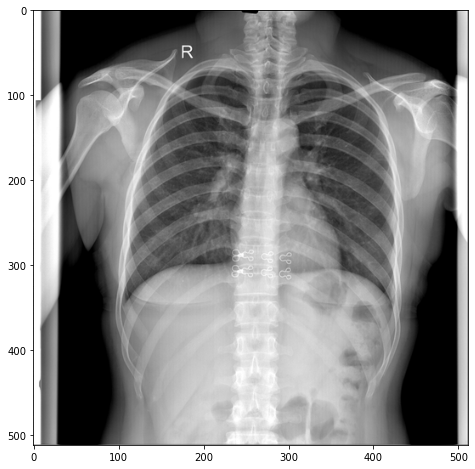

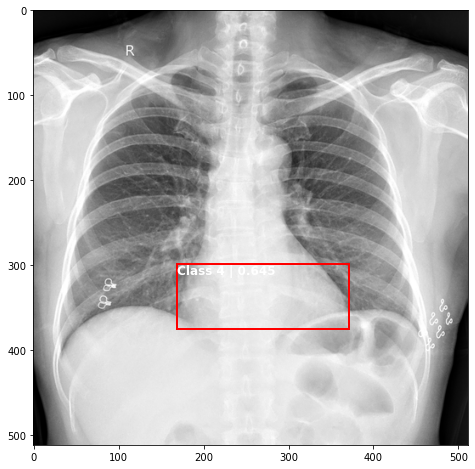

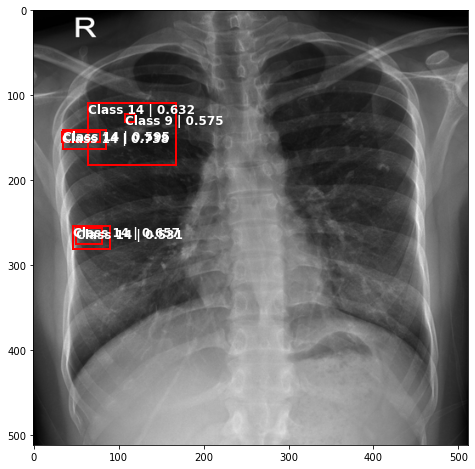

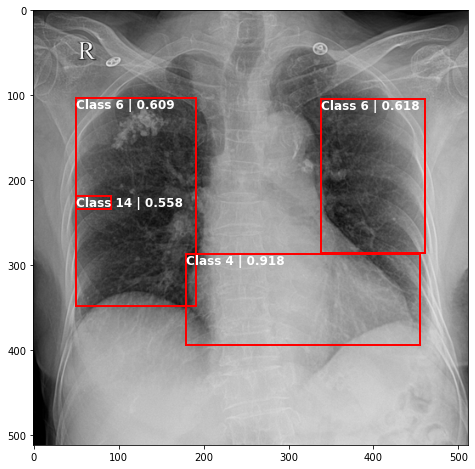

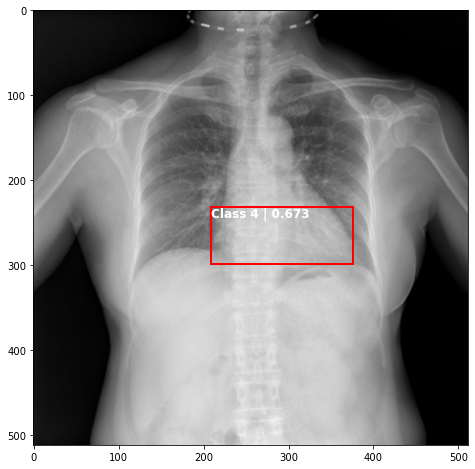

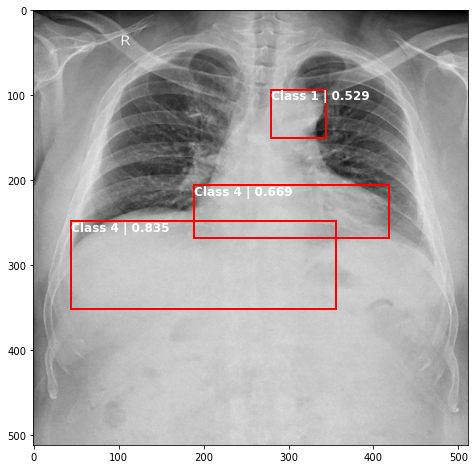

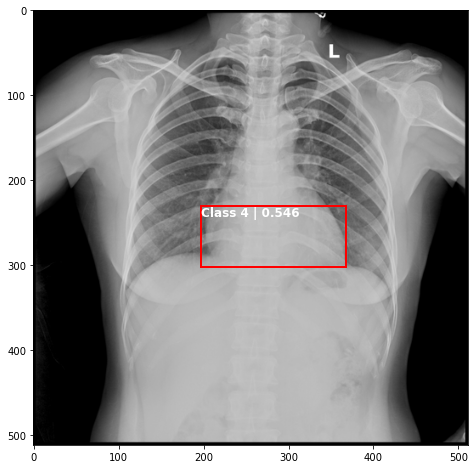

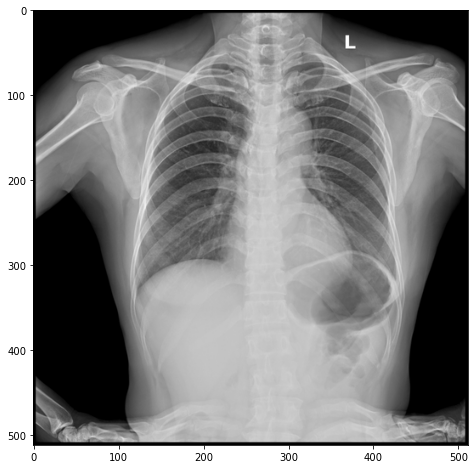

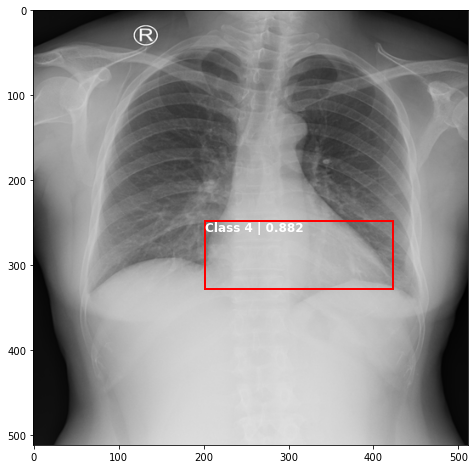

In [462]:
j = -1
for i in range(20):
    if i%8==0:
        j+=1
    ts_img,_,_,_ = TCDS[i]
    plot_valid(ts_img,results[j][i%8],False)